In [2]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload
%autoreload 2

In [32]:
from audioDataset import AudioDataset
from utils import *
from scipy.io import wavfile
import os
from scipy.signal import stft, istft, check_NOLA # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
from dimensionalityReduction import decomposeAudioSKLearn, decomposeAudio, getPCA
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore") # To ignore the warnings hmmlearn causes
from sklearn.mixture import GaussianMixture
import IPython


dict_keys(['keyboard', 'string'])
[321, 814]
dict_keys(['keyboard', 'string'])
[79, 98]
{'window': 'hann', 'nperseg': 2048, 'noverlap': 1024}


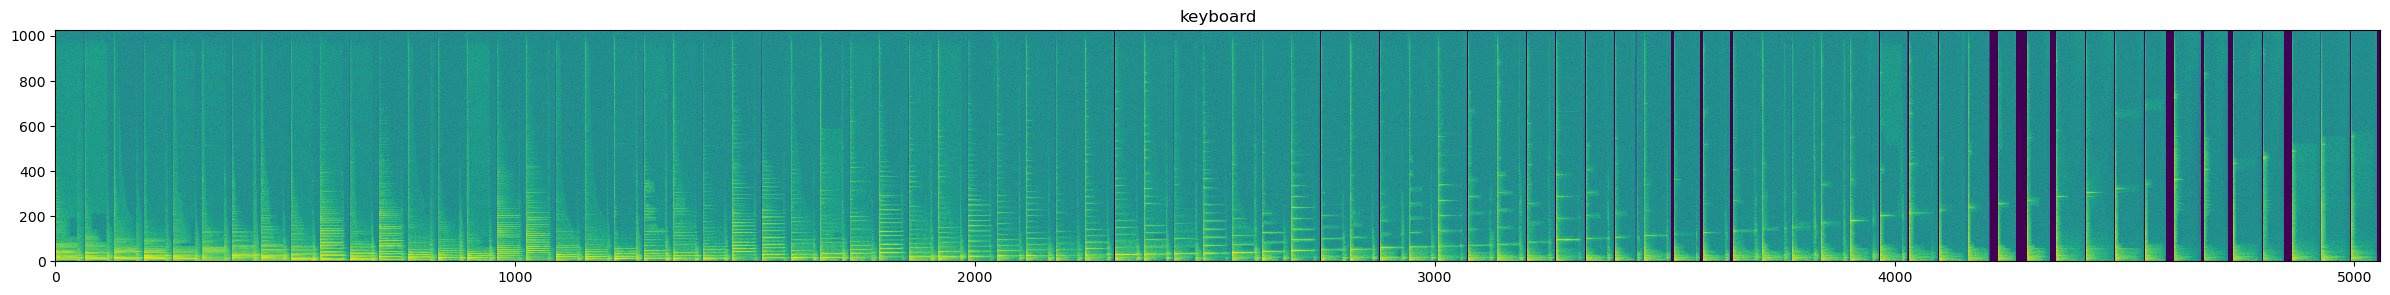

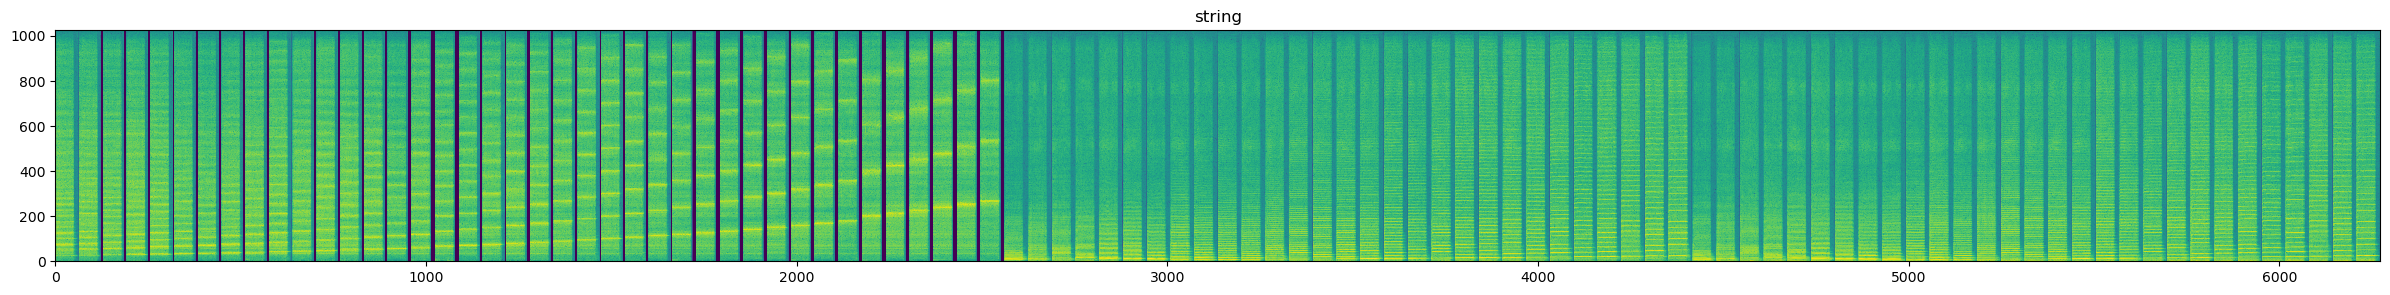

keyboard has 5056 frames
Pruned 188 frames from keyboard
string has 6272 frames
Pruned 269 frames from string


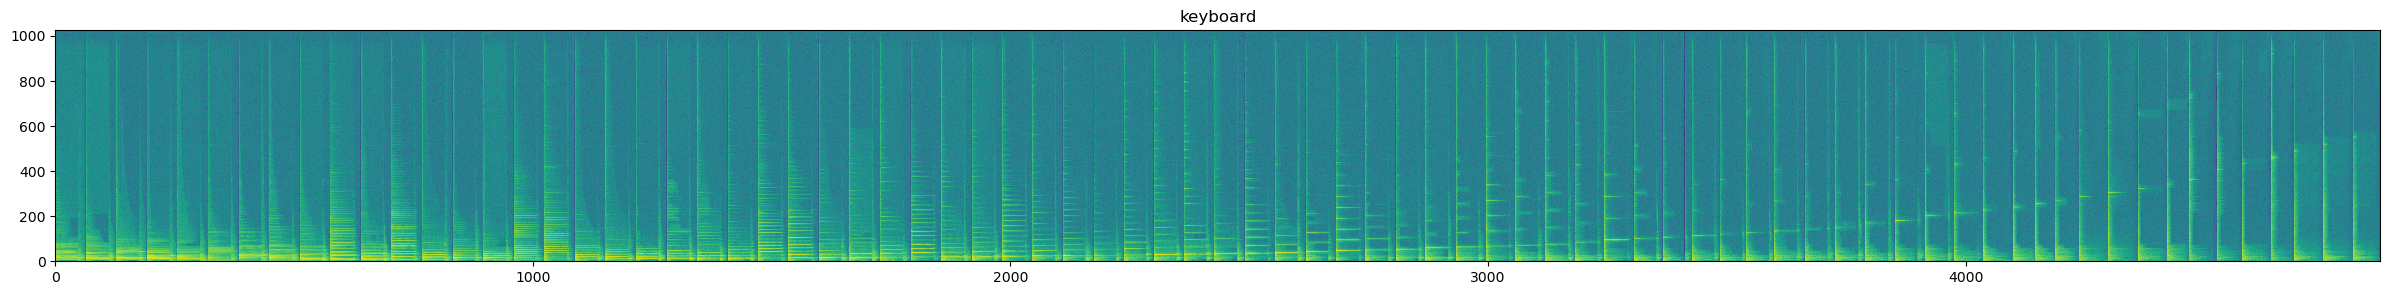

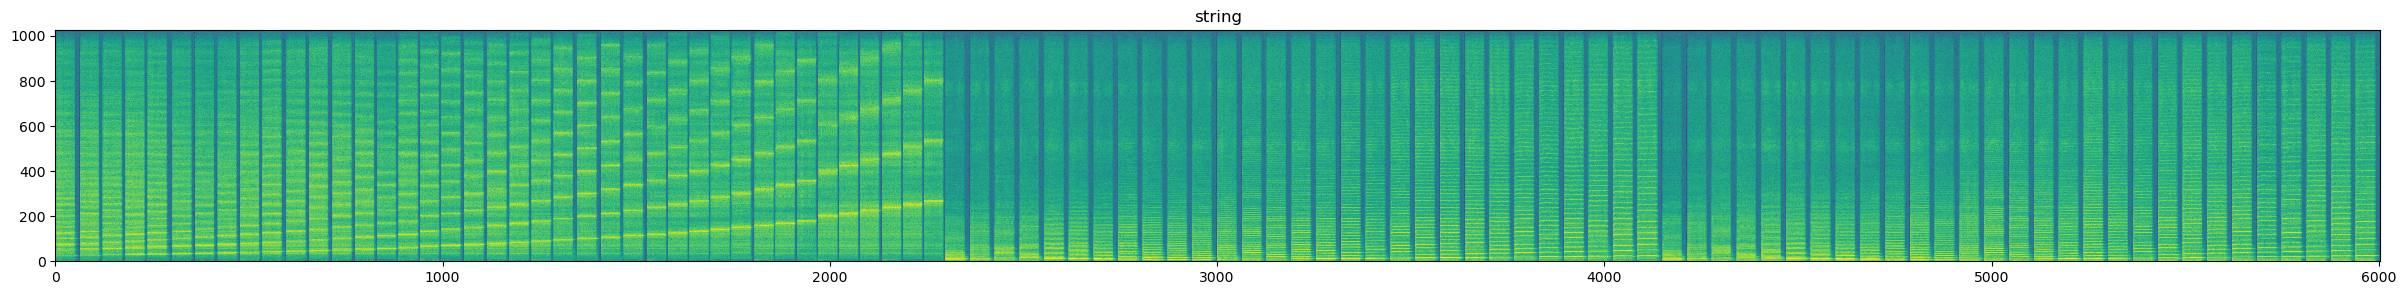

In [34]:
# audioDataset = AudioDataset('nsynth-valid', instruments=['keyboard', 'string', 'brass'], kwargs={'nsynth_getAcousticOnly':True})
audioDataset = AudioDataset('nsynth-valid', instruments=['keyboard', 'string'], kwargs={'nsynth_getAcousticOnly':True})
# audioDataset.normalizeAudioData_()
data = audioDataset.getAudioData()
print(data.keys())
print([len(val) for val in data.values()])

# TODO: When deleting redundant audio data with all NSynth acoustic instruments, the last 3 instruments get completely removed. This may be a bug
audioDataset.deleteRedundantAudioData(pitchInterval=1, writeDebugFiles=True)
data = audioDataset.getAudioData() # data is all float32, but seems the same range
print(data.keys())
print([len(val) for val in data.values()])

# audioDataset.normalizeAudioData_()

audioDataset.setSpectrogramKwargs({'window': 'hann', 'nperseg':2048, 'noverlap':1024})
print(audioDataset.getSpectrogramKwargs())

audioDataset.createSpectrogramsIndependent(deleteAudioData=False)

# Display the spectrograms for each instrument before and after low energy pruning
PRUNE_THRESHOLD = 1e-4
audioDataset.displayInstrumentSpectrograms()
# audioDataset.removeLowEnergyFrames_(threshold=10000)
audioDataset.removeLowEnergyFrames_(threshold=PRUNE_THRESHOLD)
audioDataset.displayInstrumentSpectrograms()

audioDataset.writeBasisFunctionAudioFiles()

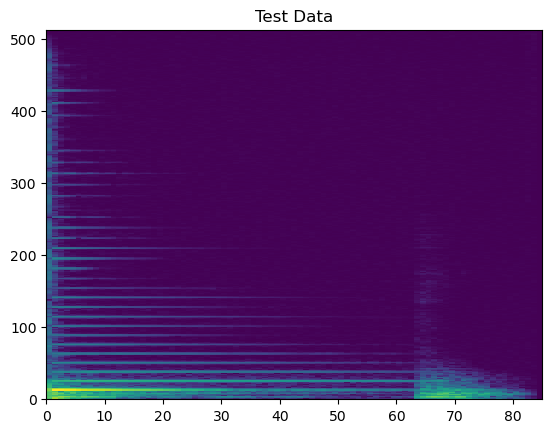

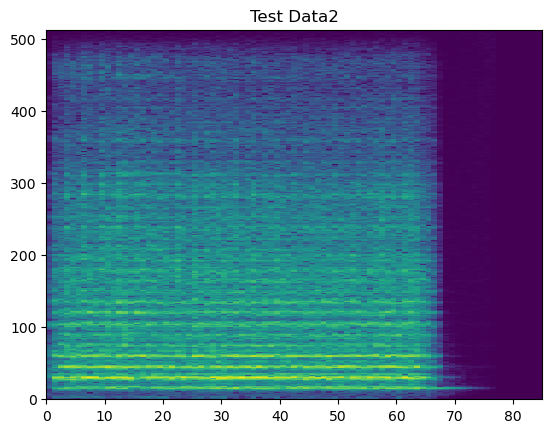

(<matplotlib.collections.QuadMesh at 0x24ccf64e9b0>,
 Text(0.5, 1.0, 'Test Data2'),
 None)

In [5]:
TEST_FILENAME = r'debug-samples\debugSamplekeyboard_acoustic_004-055-025.wav.wav'
TEST_FILENAME2 = r'debug-samples\debugSamplestring_acoustic_057-058-025.wav.wav'

fs, rawData = wavfile.read(TEST_FILENAME) # read as int16
fs, rawData2 = wavfile.read(TEST_FILENAME2) # read as int16

rawData = normalizeWAV(rawData)
rawData2 = normalizeWAV(rawData2)

mixture = normalizeWAV(rawData + rawData2)
writable = convertFloat32toInt16(mixture)

audioDataset._writeDebugSample(writable, 'Mixture string-piano')

testSpectrogram = audioDataset.getMagnitudeSpectrogram(rawData, fs=fs)
testSpectrogram2 = audioDataset.getMagnitudeSpectrogram(rawData2, fs=fs)

plt.pcolormesh(np.log(testSpectrogram+1e-5)), plt.title('Test Data'), plt.show()
plt.pcolormesh(np.log(testSpectrogram2+1e-5)), plt.title('Test Data2'), plt.show()

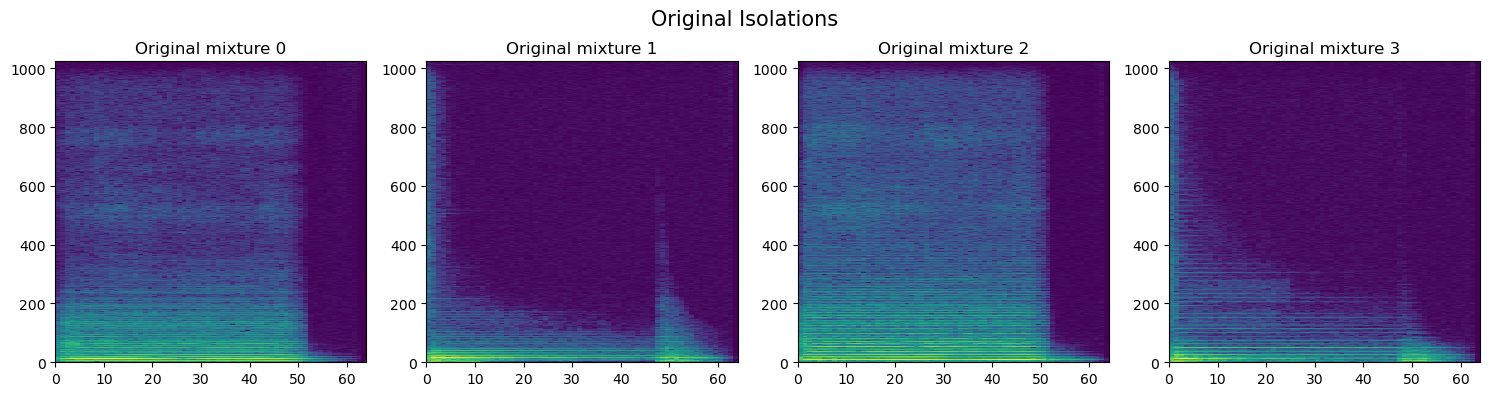

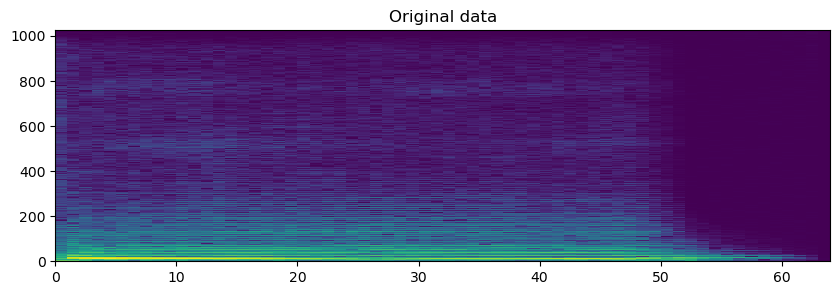

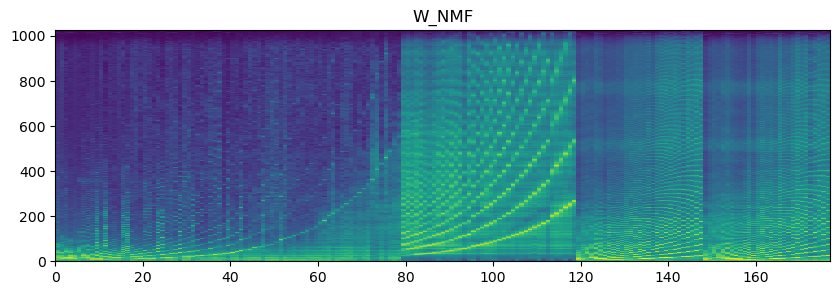

Finished after 5999 iterations


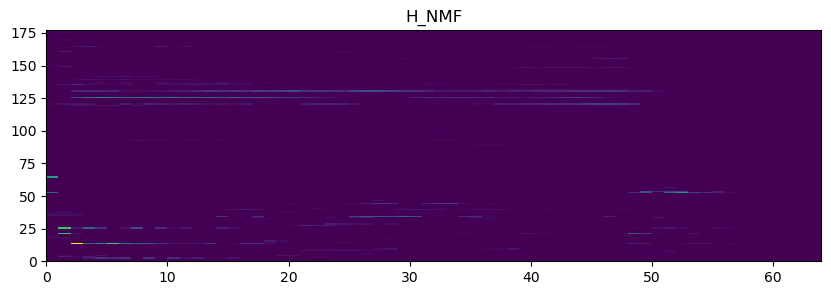

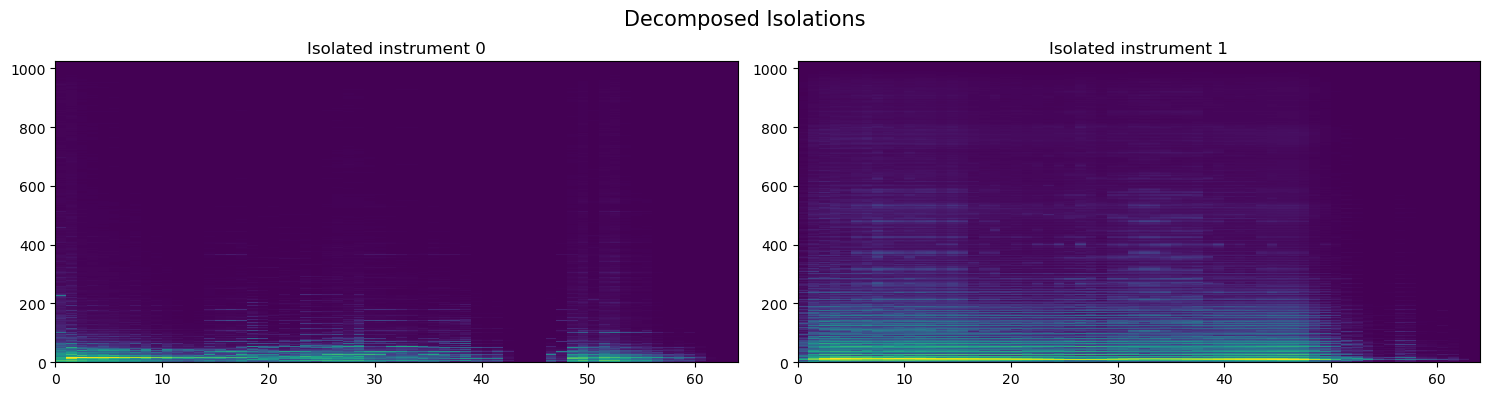

minSpec: (-0.152839794754982-0.0908297523856163j) maxSpec: (0.14831534028053284+0.08237534761428833j)
minRaw: -32767 maxRaw: 25669


In [45]:
def combineArrays(arrays, overlap):
    
    """
    Combines a list of arrays into a larger array with specified overlap.
    
    This is used for mixing individual samples at different offsets to evaluate how NMF does at separating the data
    """

    arrayLength = len(arrays[0])

    totalLength = arrayLength + (len(arrays) - 1) * (arrayLength - overlap)
    result = np.zeros(totalLength)

    # Add each array to the resulting array at the correct position
    for i, array in enumerate(arrays):
        start = i * (arrayLength - overlap)
        end = start + arrayLength
        result[start:end] += array

    return result

F1 = r'debug-samples\debugSamplestring_acoustic_071-031-025.wav.wav'
# F2 = r'debug-samples\debugSamplestring_acoustic_071-035-025.wav.wav'
F3 = r'debug-samples\debugSamplestring_acoustic_071-037-100.wav.wav'
# F4 = r'debug-samples\debugSamplestring_acoustic_071-043-025.wav.wav'

# F1 = r'debug-samples\debugSamplekeyboard_acoustic_004-031-100.wav.wav'
F2 = r'debug-samples\debugSamplekeyboard_acoustic_004-035-025.wav.wav'
# F3 = r'debug-samples\debugSamplekeyboard_acoustic_004-037-100.wav.wav'
F4 = r'debug-samples\debugSamplekeyboard_acoustic_004-043-025.wav.wav'

# audioMixtures, spectrogramMixtures, audioSeparated, spectrogramSeparated = audioDataset.createRandomMixtures(mixtureCount=2, samplesPerMixture=2)
# audioSeparated = [y for x in audioSeparated for y in x]

FNAMES = [F1, F2, F3, F4]

audioSeparated = [normalizeWAV(wavfile.read(F)[1]) for F in FNAMES]

minSize = min([x.shape[0] for x in audioSeparated])
clippedAudioSeparated = [normalizeWAV(x[:minSize]) for x in audioSeparated]


fullMixture = normalizeWAV(combineArrays(clippedAudioSeparated, overlap=int(minSize//2)))



fig, axes = plt.subplots(1, len(clippedAudioSeparated), figsize=(15, 4))
for i, originalSample in enumerate(clippedAudioSeparated):
    audioDataset._writeDebugSample(data=originalSample, fn=f'_original{i}')
    axes[i].pcolormesh(np.log(np.abs(audioDataset.getMagnitudeSpectrogram(normalizeWAV(originalSample), fs=fs))+1e-6)), axes[i].set_title(f'Original mixture {i}')
    
plt.tight_layout()
fig.suptitle('Original Isolations', fontsize=15), plt.subplots_adjust(top=0.85)
plt.show()


isolations = audioDataset.runNMFAudioDecomposition(fullMixture, nmfRegularization=0.005, iterations=6000)
